In [13]:
# !pip install "pytensor>=2.15.0,<2.16" "numpy<1.25"

In [ ]:
# !pip install bambi
# !pip install preliz
# !pip install numpyro
# !pip install jax
# !pip install jaxlib

In [6]:
import pymc as pm
import bambi as bmb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import preliz as pz
import arviz as az
import numpy as np
# import pytensor  
import jax
import numpyro
import blackjax
import nutpie
import gdown
import tempfile
# pytensor.config.floatX = "float32"

In [7]:
jax.local_device_count()

1

In [6]:
numpyro.set_host_device_count(4)

In [ ]:
jax.config.update("jax_platform_name", "cpu")

In [9]:
file_id = "1P2-DrRmHUoO7d8lmZ480xrmbrGuxpCoI"
url = f"https://drive.google.com/uc?id={file_id}"

try:
    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp:
        tmp_path = tmp.name

    gdown.download(url, tmp_path, quiet=False)

    df = pd.read_pickle(tmp_path)
except Exception as e:
    print("No data on g-drive")

Downloading...
From: https://drive.google.com/uc?id=1P2-DrRmHUoO7d8lmZ480xrmbrGuxpCoI
To: C:\Users\kugor\AppData\Local\Temp\tmpdwd_mob6.csv
100%|██████████| 24.4M/24.4M [00:01<00:00, 14.5MB/s]


In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_pickle('/content/drive/MyDrive/data_resampled.csv')
    print("Data loaded from Google Drive.")
except Exception as e:
    print("No data")

No data


In [4]:
try:
  df = pd.read_pickle("../data/interim/data_resampled.csv")
except:
  print("no data in colab session")

In [7]:
###### SAMPLE 30k ROWS ##########
file_id = "13HsgCri_zp1USVP2fYmMOWPx0SALzReM"
url = f"https://drive.google.com/uc?id={file_id}"

try:
    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp:
        tmp_path = tmp.name

    gdown.download(url, tmp_path, quiet=False)

    df = pd.read_pickle(tmp_path)
except Exception as e:
    print("No data on g-drive")

Downloading...
From: https://drive.google.com/uc?id=13HsgCri_zp1USVP2fYmMOWPx0SALzReM
To: C:\Users\kugor\AppData\Local\Temp\tmpmduxd3ak.csv
100%|██████████| 2.45M/2.45M [00:02<00:00, 1.21MB/s]


In [8]:
df["stress"] = df["label"].replace({
    "Brak stresu": 0,
    "Niski/Średni": 1,
    "Wysoki": 2
})

C:\Users\kugor\AppData\Local\Temp\ipykernel_14088\3318738806.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["stress"] = df["label"].replace({


In [9]:
cat_nurse = pd.Categorical(df['id'])
df["nurse_idx"] = cat_nurse.codes
n_nurses = len(cat_nurse.categories)
coords = {"nurse": cat_nurse.categories,
          "stress": ["Niski/Średni", "Wysoki"]}
stress = df["stress"].values
nurse_idx = df["nurse_idx"].values
temp = df["TEMP"].values
df=pd.concat([pd.get_dummies(df, columns=["label"], dtype="int32", drop_first=True), df['label']], axis=1)

<Axes: >

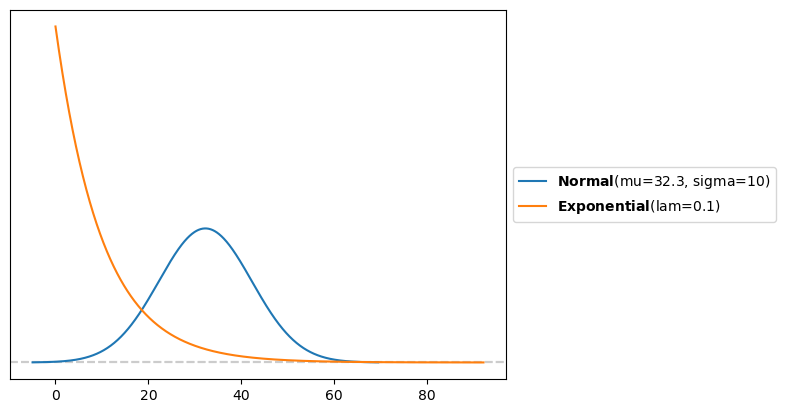

In [25]:
pz.Normal(mu=df["TEMP"].mean(), sigma=10).plot_pdf()
pz.Exponential(0.1).plot_pdf()

#### Unpooled model, fitting a normal distribution for TEMP variable

In [ ]:
# Trying non-pooled model first
with pm.Model(coords=coords) as unpooled_model:
    # priors
    mu = pm.Normal("mu", mu=df["TEMP"].mean(), sigma=1, dims="nurse")
    sigma=pm.Exponential("sigma", 0.1, dims="nurse")
    # likelihood
    y_temp = pm.Normal("y_temp", mu=mu[nurse_idx], sigma=sigma[nurse_idx], observed=df['TEMP'])

    unpooled_idata = pm.sample(chains=2)

pm.model_to_graphviz(unpooled_model)

NameError: name 'idx' is not defined

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

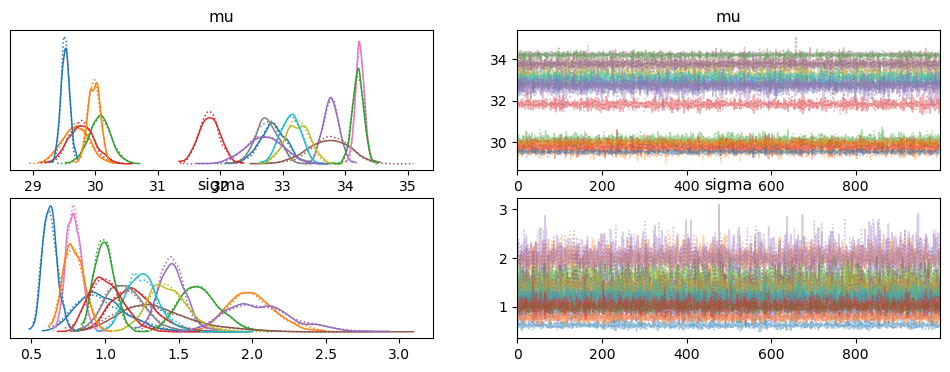

In [ ]:
az.plot_trace(unpooled_idata)

#### Linear regression, effect of stress on TEMP, ordinal stress encoding, no pooling

In [10]:
with pm.Model(coords=coords) as non_pooled_model_reg:
    # independent priors for each nurse
    alpha = pm.Normal("alpha", mu=36, sigma=5, dims="nurse")
    beta = pm.Normal("beta", mu=0, sigma=2, dims="nurse")

    sigma = pm.Exponential("sigma", 1.0, dims="nurse")

    # Expected temperature for each observation
    mu = alpha[nurse_idx] + beta[nurse_idx] * stress

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=temp)

    # Sample
    idata_np_reg = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, idata_kwargs={"log_likelihood": True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2993 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


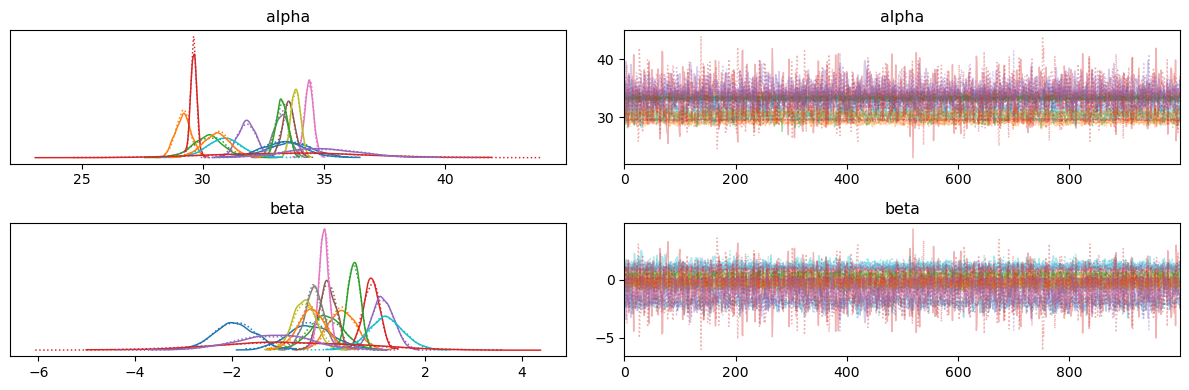

In [10]:
az.plot_trace(idata_np_reg, var_names=["alpha", "beta"], compact=True); plt.tight_layout()
# plt.savefig(f"../reports/figures/{var}_no_pool_ord_trace.png", bbox_inches="tight")

In [ ]:
az.summary(idata_np_reg, kind="stats").head()

,mean,sd,hdi_3%,hdi_97%
alpha[15],34.072,0.164,33.778,34.378
alpha[5C],29.296,0.047,29.204,29.381
alpha[6B],30.164,0.077,30.006,30.298
alpha[6D],29.575,0.020,29.539,29.615
alpha[7A],31.830,0.054,31.727,31.929


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

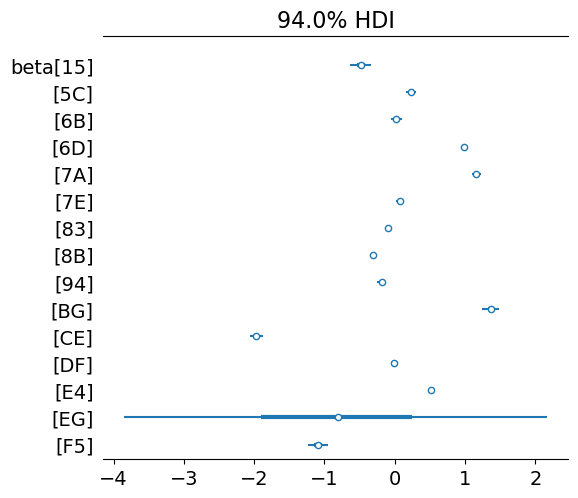

In [ ]:
az.plot_forest(idata_np_reg, var_names="beta", combined=True)

Sampling: [y_obs]


<Axes: xlabel='y_obs / y_obs'>

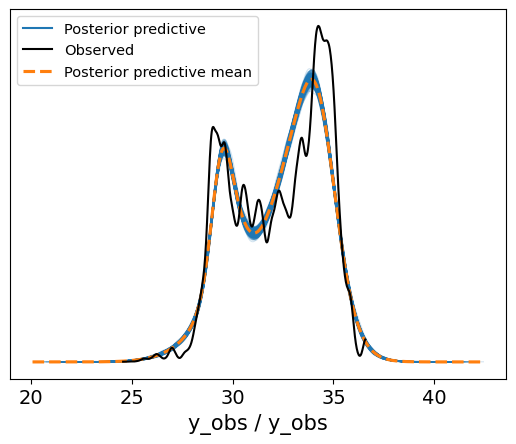

In [ ]:
pm.sample_posterior_predictive(idata_np_reg, non_pooled_model_reg, extend_inferencedata=True)
az.plot_ppc(idata_np_reg, num_pp_samples=1000)

Testing with bambi, same model still

In [ ]:
model_np_reg = bmb.Model("TEMP ~ stress + (stress | id)", data=df)

# Fit the model with log_likelihoods included for az.compare()
# idata_np_reg = model_np_reg.fit(draws=1000, tune=1000, chains=2, target_accept=0.9, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [TEMP_sigma, Intercept, stress, 1|id_sigma, 1|id_offset, stress|id_sigma, stress|id_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='stress', ylabel='TEMP'>], dtype=object))

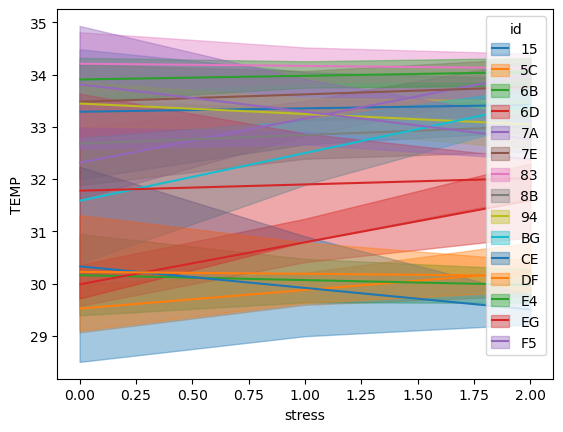

In [ ]:
# bmb.interpret.plot_predictions(model_np_reg, idata_np_reg, ["stress", "id"])

##### One-hot encoded stress to capture effect on TEMP on each level of stress
* Also testing samplers

In [10]:
def run_model(sampler):
    with pm.Model(coords=coords) as non_pooled_model_reg_oh:
        # independent priors for each nurse
        alpha = pm.Normal("alpha", mu=36, sigma=5, dims="nurse")
        beta_0 = pm.Normal("beta_0", mu=0, sigma=2, dims="nurse")
        beta_1 = pm.Normal("beta_1", mu=0, sigma=2, dims="nurse")

        sigma = pm.Exponential("sigma", 1.0, dims="nurse")

        # Expected temperature for each observation
        mu = alpha[nurse_idx] + beta_0[nurse_idx] * df['label_Niski/Średni'] + beta_1[nurse_idx] * df['label_Wysoki']

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=temp)

        # Sample
        idata_np_reg_oh = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, idata_kwargs={"log_likelihood": True}, nuts_sampler=sampler)
        
        return non_pooled_model_reg_oh, idata_np_reg_oh

In [11]:
nuts_model, nuts_idata = run_model("pymc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_0, beta_1, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 69 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
numpyro_model, numpyro_idata = run_model("numpyro")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
blackjax_model, blackjax_idata = run_model("blackjax")

Running window adaptation


KeyboardInterrupt: 

In [14]:
nutpie_model, nutpie_idata = run_model("nutpie")

c:\Users\kugor\anaconda3\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:330: UserWarning: `idata_kwargs` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.16,95
,2000,0,0.16,63


In [16]:
az.loo(nuts_idata)

c:\Users\kugor\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1455.76    29.30
p_loo       47.37        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      997   99.7%
   (0.70, 1]   (bad)         2    0.2%
   (1, Inf)   (very bad)    1    0.1%

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

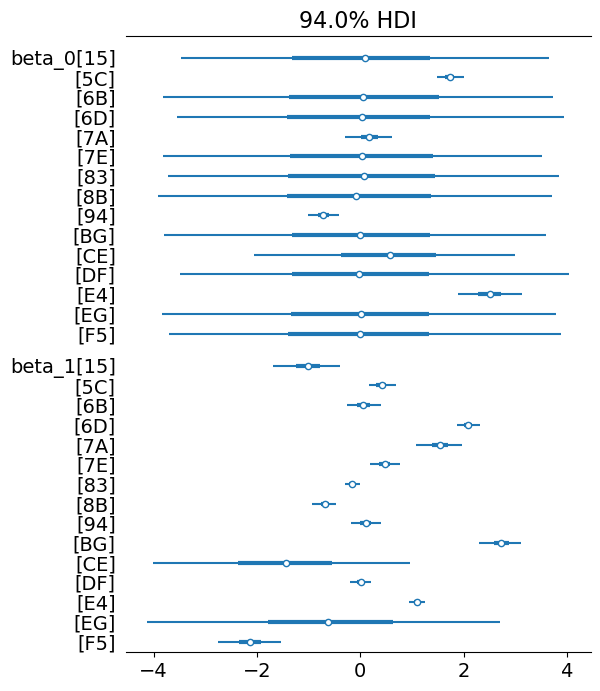

In [14]:
az.plot_forest(idata_np_reg_oh, var_names=["~sigma", "~alpha"], combined=True)

In [ ]:
posterior = az.extract(idata_np_reg_oh.posterior)

ids = df['id'].unique()

means_alpha = posterior["alpha"].mean("sample").to_dataframe()
means_beta_0 = posterior["beta_0"].mean("sample").to_dataframe()
means_beta_1 = posterior["beta_1"].mean("sample").to_dataframe()

# plt.figure(figsize=(8,6))
# plt.scatter(means_intercepts, means_slopes)
mean_posterior_params = pd.concat([means_alpha, means_beta_0, means_beta_1], axis=1);

<Figure size 640x480 with 0 Axes>

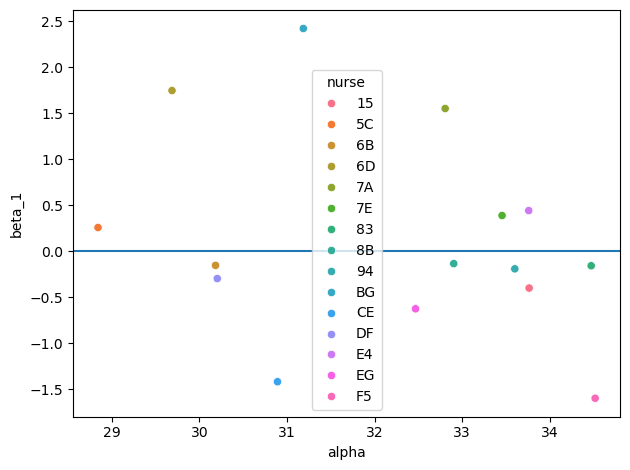

In [ ]:
sns.scatterplot(data=mean_posterior_params, x="alpha", y="beta_1", hue=mean_posterior_params.index);
plt.axhline(0)
plt.tight_layout()


Sampling: [y_obs]


<Axes: xlabel='y_obs / y_obs'>

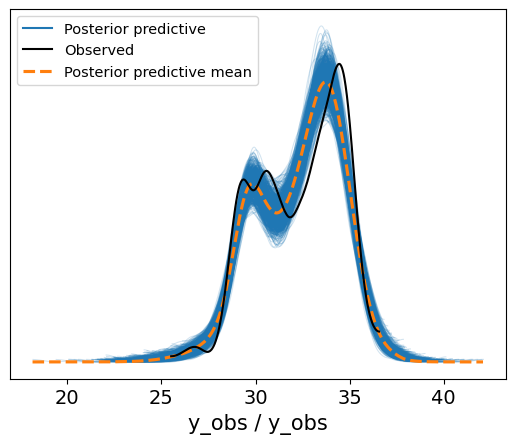

In [ ]:
pm.sample_posterior_predictive(idata_np_reg_oh, non_pooled_model_reg_oh, extend_inferencedata=True)
az.plot_ppc(idata_np_reg_oh, num_pp_samples=1000)

#### Hierarchical linear regression TEMP ~ STRESS, non-centered parametrization (modelling common slope and then offsets for groups)
* Using bambi

In [ ]:
h_reg_model = bmb.Model("TEMP ~ label + (label | id)", data=df)
idata_h_reg = h_reg_model.fit(idata_kwargs={"log_likelihood":True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [TEMP_sigma, Intercept, label, 1|id_sigma, 1|id_offset, label|id_sigma, label|id_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 119 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
az.summary(idata_h_reg, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,32.059,0.576,30.980,33.141
label[Niski/Średni],0.855,1.297,-1.351,3.890
label[Wysoki],0.223,0.349,-0.422,0.901
TEMP_sigma,1.180,0.026,1.132,1.227
1|id_sigma,2.101,0.452,1.324,2.882
label|id_sigma[Niski/Średni],2.248,1.529,0.459,5.056
label|id_sigma[Wysoki],1.080,0.325,0.528,1.731
1|id[15],1.406,0.750,-0.019,2.832
1|id[5C],-3.239,0.601,-4.450,-2.209
1|id[6B],-1.935,0.667,-3.200,-0.697


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

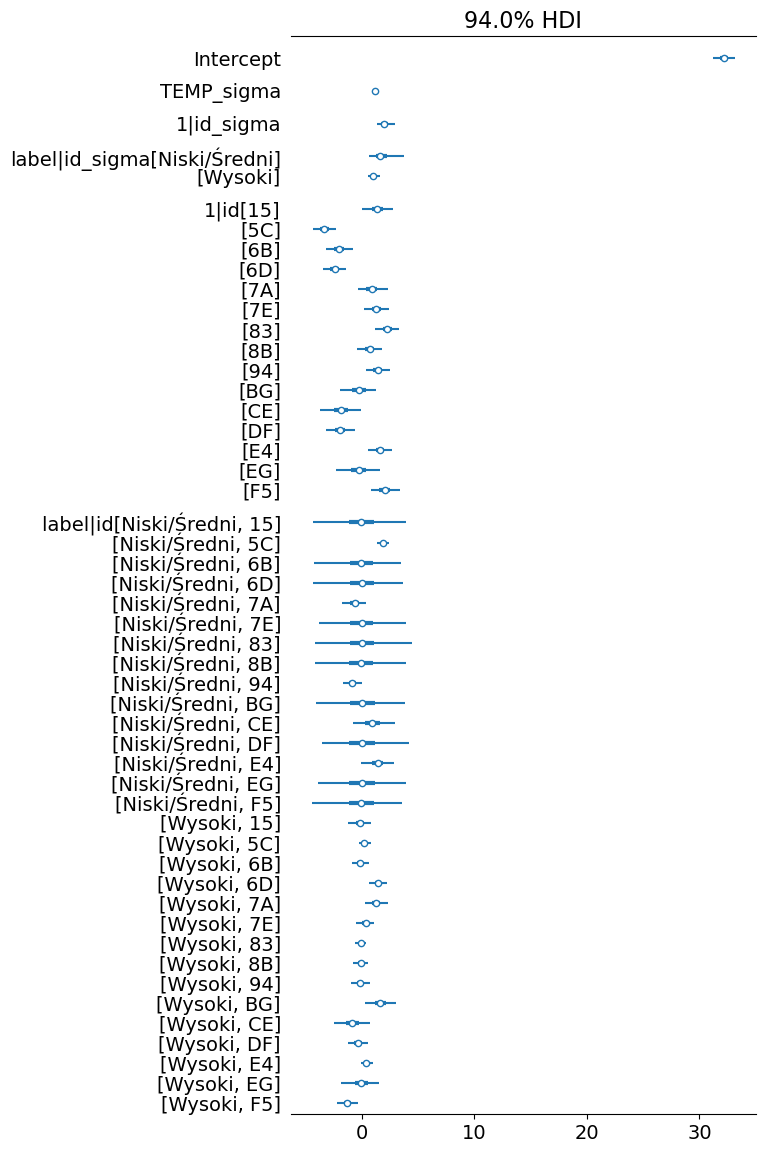

In [ ]:
az.plot_forest(idata_h_reg, combined=True)

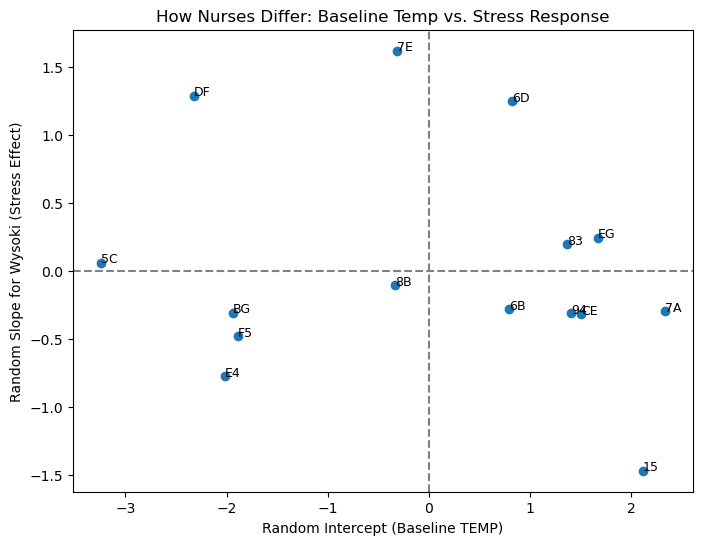

In [ ]:
idata = idata_h_reg.posterior

ids = df['id'].unique()

means_intercepts = idata["1|id"].mean(dim=("chain", "draw")).values
means_slopes = idata["label|id"].sel(label__expr_dim="Wysoki").mean(dim=("chain", "draw")).values

plt.figure(figsize=(8,6))
plt.scatter(means_intercepts, means_slopes)
for i, label in enumerate(ids):
    plt.text(means_intercepts[i], means_slopes[i], str(label), fontsize=9)

plt.xlabel("Random Intercept (Baseline TEMP)")
plt.ylabel("Random Slope for Wysoki (Stress Effect)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("How Nurses Differ: Baseline Temp vs. Stress Response")
plt.show()

Comparing
* Non-pooled, linear regression of STRESS on TEMP, ordinal category encoding
* Non-pooled, linear regression of STRESS on TEMP, one-hot encoding
* Partially pooled, linear regression of STRESS on TEMP, non-centerd parametrization

In [ ]:
model_dict = {
    "Ordinal Encoding": idata_np_reg,
    "One-Hot Encoding": idata_np_reg_oh,
    "Partially pooled": idata_h_reg
}

az.compare(model_dict)


c:\Users\Kuba\miniconda3\envs\bap3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\bap3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\bap3\Lib\site-packages\arviz\sta

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
One-Hot Encoding,0,-1503.876494,46.124527,0.000000,5.488011e-01,29.236123,0.000000,True,log
Ordinal Encoding,1,-1544.215387,42.897367,40.338893,4.511989e-01,29.833488,41.110174,True,log
Partially pooled,2,-1601.789649,33.998800,97.913154,8.659740e-15,35.897601,17.181934,False,log


In [26]:
df

,id,X,Y,Z,EDA,HR,TEMP,stress,nurse_idx,label_Niski/Średni,label_Wysoki,label
datetime,,,,,,,,,,,,
2020-04-14 22:31:00,5C,-21.993750,-43.437500,127.00000,22.103413,82.316,36.500,1,1,1,0,Niski/Średni
2020-04-14 22:31:10,5C,-22.018750,-43.400000,127.00000,22.298288,81.118,36.499,1,1,1,0,Niski/Średni
2020-04-14 22:31:20,5C,-22.028125,-43.534375,127.00000,22.046580,80.156,36.495,1,1,1,0,Niski/Średni
2020-04-14 22:31:30,5C,-22.056250,-43.303125,127.00000,21.413281,79.878,36.497,1,1,1,0,Niski/Średni
2020-04-14 22:31:40,5C,-22.075000,-43.381250,127.00000,21.335523,79.831,36.488,1,1,1,0,Niski/Średni
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-13 08:00:20,83,-30.862500,4.712500,52.26250,5.573162,70.637,33.950,2,6,0,1,Wysoki
2020-12-13 08:00:30,83,-35.256250,9.278125,42.05625,5.236739,70.649,33.973,2,6,0,1,Wysoki
2020-12-13 08:00:40,83,-47.475000,3.806250,42.31250,5.040609,70.616,33.966,2,6,0,1,Wysoki


In [ ]:
# ==== Modeling ====
models = {"TEMP": {}, "EDA": {}, "HR": {}}
idata = {"TEMP": {}, "EDA": {}, "HR": {}}

for var in ["TEMP", "EDA", "HR"]:
    outcome = df[var].values

    # === No Pooling - Ordinal ===
    with pm.Model(coords=coords) as m_np_ord:
        alpha = pm.Normal("alpha", mu=df[var].mean(), sigma=5, dims="nurse")
        beta = pm.Normal("beta", mu=0, sigma=2, dims="nurse")
        sigma = pm.Exponential("sigma", 1.0, dims="nurse")
        mu = alpha[nurse_idx] + beta[nurse_idx] * stress
        pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=outcome)
        idata_np_ord = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                 idata_kwargs={"log_likelihood": True},
                                 cores=4)

    models[var]["no_pool_ord"] = m_np_ord
    idata[var]["no_pool_ord"] = idata_np_ord

    az.plot_trace(idata_np_ord); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_no_pool_ord_trace.png", bbox_inches="tight")
    
    # === No Pooling - One-Hot ===
    with pm.Model(coords=coords) as m_np_oh:
        alpha = pm.Normal("alpha", mu=df[var].mean(), sigma=5, dims="nurse")
        beta_0 = pm.Normal("beta_0", mu=0, sigma=2, dims="nurse")
        beta_1 = pm.Normal("beta_1", mu=0, sigma=2, dims="nurse")
        sigma = pm.Exponential("sigma", 1.0, dims="nurse")
        mu = (
            alpha[nurse_idx] +
            beta_0[nurse_idx] * df["label_Niski/Średni"].values +
            beta_1[nurse_idx] * df["label_Wysoki"].values
        )
        pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=outcome)
        idata_np_oh = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                idata_kwargs={"log_likelihood": True},
                                cores=4)

    models[var]["no_pool_oh"] = m_np_oh
    idata[var]["no_pool_oh"] = idata_np_oh

    az.plot_trace(idata_np_oh); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_no_pool_oh_trace.png", bbox_inches="tight")
    
    # === Partial Pooling - Hierarchical  ===
    with pm.Model(coords=coords) as m_hier:
        # Hyperpriors
        mu_alpha = pm.Normal("mu_alpha", mu=df[var].mean(), sigma=10)
        sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
        mu_beta = pm.Normal("mu_beta", mu=0, sigma=2)
        sigma_beta = pm.Exponential("sigma_beta", 1.0)

        # Group-level intercepts and slopes
        alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, dims="nurse")
        beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, dims="nurse")

        # Observation-level sigma
        sigma = pm.Exponential("sigma", 1.0, dims="nurse")

        mu = alpha[nurse_idx] + beta[nurse_idx] * stress

        pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=outcome)

        idata_hier = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                idata_kwargs={"log_likelihood": True},
                                cores=4)

    models[var]["partial_pool"] = m_hier
    idata[var]["partial_pool"] = idata_hier

    
    az.plot_trace(idata_hier); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_partial_pool_ord_trace.png", bbox_inches="tight")
    
    # === No Pooling - Heteroskedastic (Sigma ~ Stress, Varying by Nurse) ===
    with pm.Model(coords=coords) as m_sigma_dep_nurse:
        alpha = pm.Normal("alpha", mu=df[var].mean(), sigma=5, dims="nurse")
        beta_0 = pm.Normal("beta_0", mu=0, sigma=2, dims="nurse")
        beta_1 = pm.Normal("beta_1", mu=0, sigma=2, dims="nurse")

        mu = alpha[nurse_idx] + beta_0[nurse_idx] * df["label_Niski/Średni"].values + beta_1[nurse_idx] * df["label_Wysoki"].values

        # Varying intercept and slope for log(sigma)
        sigma_intercept = pm.Normal("sigma_intercept", mu=0, sigma=1, dims="nurse")
        sigma_slope = pm.Normal("sigma_slope", mu=0, sigma=1, dims="nurse")
        log_sigma = sigma_intercept[nurse_idx] + sigma_slope[nurse_idx] * stress
        sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))

        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=outcome)

        idata_sigma_dep_nurse = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                          idata_kwargs={"log_likelihood": True},
                                          cores=4)

    models[var]["no_pool_sigma_dep"] = m_sigma_dep_nurse
    idata[var]["no_pool_sigma_dep"] = idata_sigma_dep_nurse

    az.plot_trace(idata_sigma_dep_nurse); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_sigma_dep_trace.png", bbox_inches="tight")

    pd.to_pickle(az.compare(idata[var]), f"../data/processed/{var}_model_comparison.pkl")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

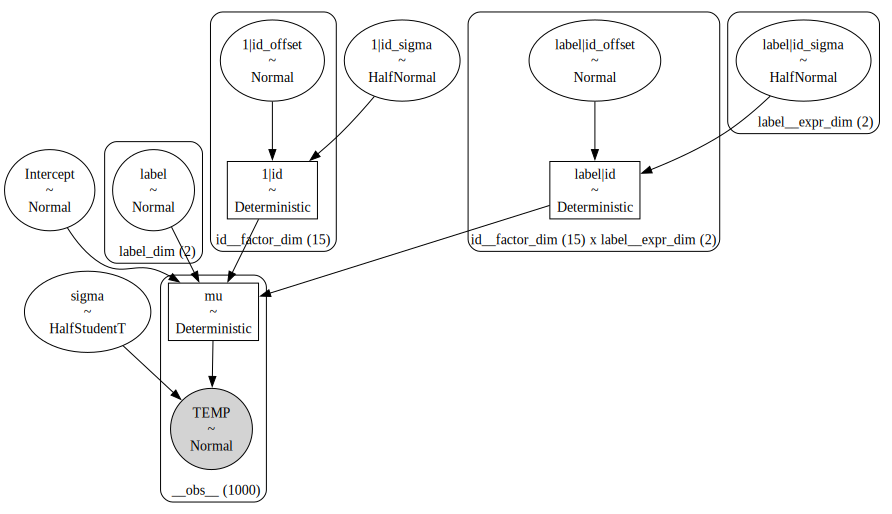

In [26]:
models['TEMP']['partial_pool'].graph()

In [20]:
az.compare(idata['TEMP'])

c:\Users\Kuba\miniconda3\envs\pymc_env_numpyro\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\pymc_env_numpyro\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\pymc_e

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
no_pool_sigma_dep,0,-1440.947143,54.237168,0.000000,8.843755e-01,30.730139,0.000000,True,log
no_pool_oh,1,-1497.436815,44.736362,56.489672,6.731515e-02,28.252498,13.101878,True,log
no_pool_ord,2,-1508.807995,41.252337,67.860852,9.643847e-16,29.004602,13.989226,True,log
partial_pool,3,-1588.757618,34.562793,147.810475,4.830932e-02,34.051989,20.905572,True,log


In [21]:
az.compare(idata['HR'])

c:\Users\Kuba\miniconda3\envs\pymc_env_numpyro\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\pymc_env_numpyro\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\pymc_e

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
no_pool_sigma_dep,0,-3999.761619,57.804792,0.000000,0.402942,30.919867,0.000000,True,log
partial_pool,1,-4002.892391,24.612162,3.130772,0.408111,32.170317,10.976263,False,log
no_pool_ord,2,-4011.725721,50.946720,11.964102,0.188948,37.731483,10.994035,True,log
no_pool_oh,3,-4013.245415,49.164972,13.483797,0.000000,37.742594,10.993764,True,log


In [22]:
az.compare(idata['EDA'])

c:\Users\Kuba\miniconda3\envs\pymc_env_numpyro\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\pymc_env_numpyro\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\pymc_e

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
no_pool_sigma_dep,0,-2054.633203,107.849109,0.000000,7.843393e-01,88.963513,0.000000,True,log
no_pool_oh,1,-2186.855325,94.678499,132.222121,1.913114e-01,88.766395,28.951991,True,log
no_pool_ord,2,-2189.656959,98.913971,135.023756,8.688286e-15,90.288313,29.269688,True,log
partial_pool,3,-2968.197935,43.335892,913.564732,2.434929e-02,64.649539,83.586119,True,log


Output()

<Axes: xlabel='y_obs'>

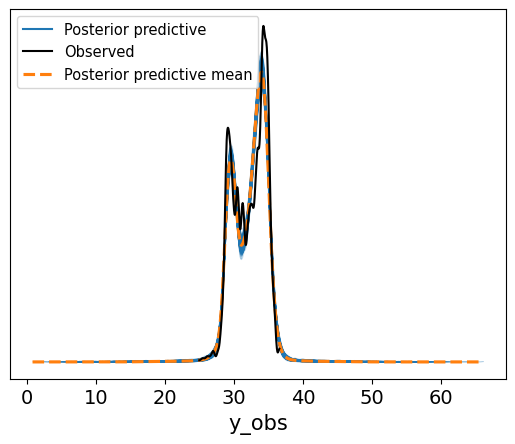

In [31]:
pm.sample_posterior_predictive(idata['TEMP']['no_pool_sigma_dep'], models['TEMP']['no_pool_sigma_dep'], extend_inferencedata=True)
az.plot_ppc(idata['TEMP']['no_pool_sigma_dep'], num_pp_samples=1000)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'sigma_intercept'}>,
        <Axes: title={'center': 'sigma_intercept'}>],
       [<Axes: title={'center': 'sigma_slope'}>,
        <Axes: title={'center': 'sigma_slope'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

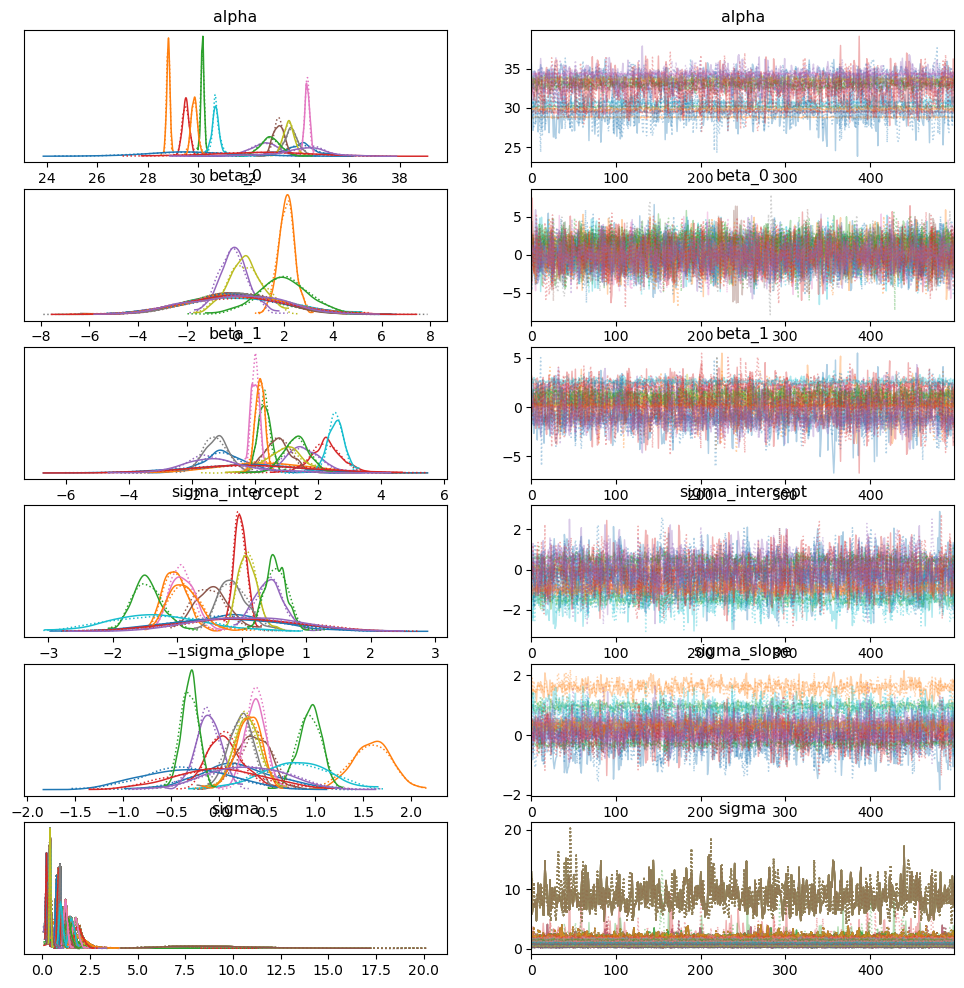

In [23]:
az.plot_trace(idata['TEMP']['no_pool_sigma_dep'])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

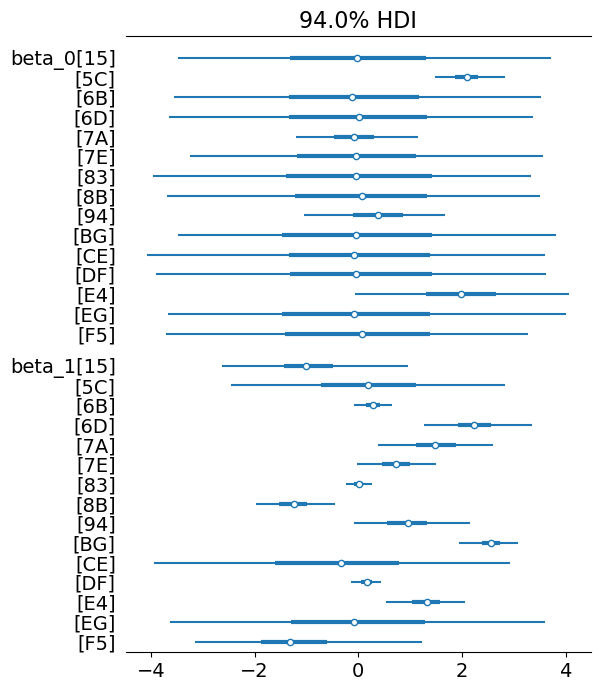

In [25]:
az.plot_forest(idata['TEMP']['no_pool_sigma_dep'], combined=True, var_names=["beta_0", "beta_1"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

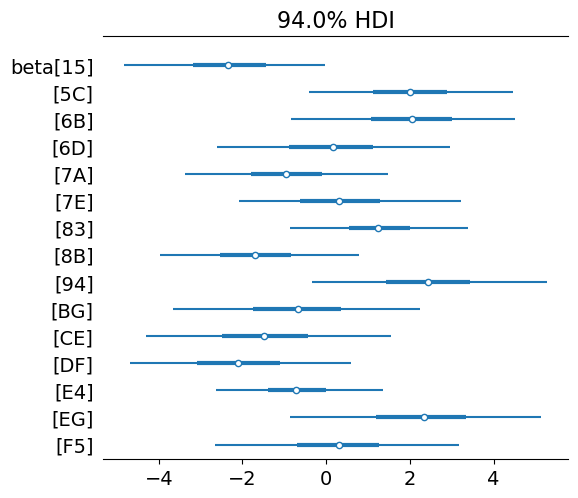

In [ ]:
az.plot_forest(idata["HR"]['no_pool_ord'],  combined=True, var_names=["beta"])

In [13]:
df.groupby("id")["label"].value_counts()

id  label       
15  Wysoki           934
    Brak stresu       43
5C  Brak stresu      967
    Niski/Średni     929
    Wysoki           820
6B  Wysoki          2230
    Brak stresu      338
6D  Brak stresu     1573
    Wysoki           278
7A  Wysoki          2969
    Niski/Średni    1119
    Brak stresu      146
7E  Wysoki           429
    Brak stresu      370
83  Wysoki          3795
    Brak stresu      514
8B  Wysoki           904
    Brak stresu      435
94  Brak stresu     1152
    Wysoki           419
    Niski/Średni     276
BG  Wysoki          1849
    Brak stresu       68
CE  Wysoki          2490
    Niski/Średni      61
DF  Wysoki          2640
    Brak stresu      206
E4  Wysoki          3739
    Brak stresu      885
    Niski/Średni      49
EG  Wysoki          1720
F5  Wysoki          1403
    Brak stresu       97
Name: count, dtype: int64